In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def generate_phenotype_df(pheno_path:str, presence_df:pd.DataFrame=None)->pd.DataFrame:
    '''
    takes in a path to a phenotype file to make a df out of it
    if a presence_df is provided, it will filter the pheno_df to only include samples that are in the presence_df

    param:
    ----
        - pheno_path: str
        - presence_df: pd.DataFrame (optional)

    return:
    ----
        - pheno_df: pd.DataFrame
    '''
    pheno_df = pd.read_csv(pheno_path, index_col=0)

    #samples stripped
    if presence_df is not None:
        samples_presence= presence_df.columns
        mask = pheno_df.index.astype(str).isin(samples_presence)
        pheno_df = pheno_df.loc[mask]

    return pheno_df

presence_path="../data/presence_matrices/Campylobacter_coli_presence_absence_T.csv"
presence_df= pd.read_csv(presence_path, index_col=0)
# presence_df.index = presence_df.index.astype(str)

for gene in presence_df.index:
    if presence_df.loc[gene].std() == 0:
        presence_df.drop(gene, inplace=True)

pheno_path="../data/phenotypes/Campylobacter_coli_ciprofloxacin.csv"
pheno_df= generate_phenotype_df(pheno_path, presence_df)

## Helpers:


By convention the presence_matrix will always deignate a GxS table where rows represent genes and columns represent samples

- split_matrix_by_phenotype(presence_matrix, phenotype_matrix): splits the presence matrix into two matrices, one R and one for S

In [2]:
def split_matrix_by_phenotype(unlabeled_presence_df:pd.DataFrame, pheno_df: pd.DataFrame)->(pd.DataFrame, pd.DataFrame):
    '''
    takes a gene absence presence dataframe (n x m) with the samples classification and splits it to 2 dataframes:
        - one that represents all R samples (samples found in R_list)
        - one that represents all S samples (found in S_list)
    and returns them in this order: R then S

    param:
    ------
        - unlabeled_presence_df: (pd.DataFrame) the data frame output of data_utils.get_gene_presence_matrix
        - R_list: (list) samples genome_id that have a R (1) phenotype
        - S_list: (list) samples having the 0 phenotype
    
    return:
    ------
        - R_df: (pd.DataFrame) data frame where columns are only for R samples
        - S_df: (pd.DataFrame) df where cols are only for S samples

    '''


    # make sure pheno_df doesnthave more samples than those specified in the presence_df, subsample it otherwise
    samples_presence= unlabeled_presence_df.columns
    mask = pheno_df.index.astype(str).isin(samples_presence)
    pheno_df = pheno_df.loc[mask]

    # get the list of R and S samples:
    R=[];S=[];U=[]
    for sample in pheno_df.index:

        if pheno_df.loc[sample].values[0]==1:
            sample=str(sample)
            R.append(str(sample))
        elif pheno_df.loc[sample].values[0]==0:
            sample=str(sample)
            S.append(str(sample))
        else:
            sample=str(sample)
            U.append(str(sample))

    # All we care for care R and S which designate the list of resistant and susceptible samples respectively

    R_df = unlabeled_presence_df[R]
    S_df = unlabeled_presence_df[S]

    #make a subdf of all columns that are in S of the presence_df
    

    return R_df, S_df

def split_samples_list_by_phenotype(pheno_df:pd.DataFrame)->(list,list):
    '''
    takes a dataframe of the phenotypes and splits the samples into 2 lists of samples

    param:
    ------
        - pheno_df: pd.DataFrame
    return:
    ------
        - R_list: list
        - S_list: list
    '''
    # get the list of R and S samples:
    R=[];S=[];U=[]
    for sample in pheno_df.index:

        if pheno_df.loc[sample].values[0]==1:
            sample=str(sample)
            R.append(str(sample))
        elif pheno_df.loc[sample].values[0]==0:
            sample=str(sample)
            S.append(str(sample))
        else:
            sample=str(sample)
            U.append(str(sample))

    return R,S

# R_df,S_df=split_matrix_by_phenotype(presence_df, pheno_df)

In [3]:
R,S=split_samples_list_by_phenotype(pheno_df)
# RS_counts_df

In [5]:
def generate_RS_presence_counts(R:pd.DataFrame, S:pd.DataFrame)->pd.DataFrame:
    '''
    Takes the presence matrix of R samples and S samples and returns a dataframe of the count of genes present and absent in each group of samples.

    *This will memoize the entries needed for the log odds ratio computation.*

    
    e.g., output (w\o the log odds):

    | Gene       | R_present | R_absent | S_present | S_absent |
    |------------|-----------|----------|-----------|----------|
    | group_1001 | 96        | 0        | 187       | 0        |
    | tig        | 96        | 0        | 187       | 0        |
    | legF_1     | 96        | 0        | 187       | 0        |

    param:
    ----------------
        - R: (pd.DataFrame) presence matrix of R samples (output of get_subdf_cols)
        - S: (pd.DataFrame) presence matrix of S samples

    return:
    ----------------
        - new_df: (pd.DataFrame) dataframe of the count of genes present and absent in each group of samples.

    NOTE: it will perform the 0.5 correction - If for one gene any of the counts is 0, it will add 0.5 to all counts for that gene.

    '''
    R_present=R.sum(axis=1)
    R_absent=R.shape[1] - R_present
    S_present=S.sum(axis=1)
    S_absent=S.shape[1]-S_present


    new_df=pd.DataFrame({'R_present':R_present, 'R_absent':R_absent, 'S_present':S_present, 'S_absent':S_absent})

    #the 0.5 correction:
    for index in new_df.index:
        row=list(new_df.loc[index])
        if 0 in row: #check if any of the cols have value 0
            new_df.loc[index]=new_df.loc[index]+0.5

    return new_df

# RS_counts_df=generate_RS_presence_counts(R_df, S_df)

#### log odds for nodes

In [ ]:


def compute_log_odds_ratio(RS_counts_df:pd.DataFrame)->pd.DataFrame:
    '''
    takes the RS_counts_df and computes the log odds ratio for each gene in the dataframe

    param:
    ------
        - RS_counts_df: pd.DataFrame


    return:
    ------
        - log_odds_df: pd.DataFrame
    '''
    #get the total number of samples in each group
    n_R=len(R); n_S=len(S)


    R_present=RS_counts_df['R_present']
    R_absent=RS_counts_df['R_absent']
    S_present=RS_counts_df['S_present']
    S_absent=RS_counts_df['S_absent']

    log_odds=np.log((R_present/R_absent)/(S_present/S_absent))

    # print(log_odds)

    df=pd.DataFrame({"log_odds":log_odds})
    return df

In [6]:
#save log_odds in a csv
log_odds_df=compute_log_odds_ratio(RS_counts_df, R, S)
# log_odds_df.to_csv("../data/log_odds_nodes/Campylobacter_coli_ciprofloxacin_log_odds.csv")

## gene-gene interactions

### memoized dont run

In [ ]:
def get_cooccurence_matrix(presence:pd.DataFrame)->pd.DataFrame:
    '''
    takes a binary GxS presence matrix and returns a GxG co-occurence matrix C 
    Cij= number of samples where gene i and gene j are both present
    (can be performed by matrix multiplication - trace on paper to understand why this works)

    input:
        - df: (pd.DataFrame) binary matrix of genes and samples
    output:
        - G: (nx.Graph) network of gene-gene presence
    '''
    gene_copresence= presence.dot(presence.T)
    return gene_copresence

# get_cooccurence_matrix(presence_df)
R_cooccurence = get_cooccurence_matrix(R_df)
S_cooccurence = get_cooccurence_matrix(S_df)
numR=len(R); numS=len(S)

In [ ]:
#save R_cpoccurence and S_cooccurence in a csv
R_cooccurence.to_csv("../data/test/Campylobacter_coli_ciprofloxacin_R_cooccurence.csv")
S_cooccurence.to_csv("../data/test/Campylobacter_coli_ciprofloxacin_S_cooccurence.csv")

In [2]:
cor_matrix=presence_df.T.corr()
gene_pairs=[]

genes_num=cor_matrix.shape[0]
for i in range(genes_num):
    for j in range(i+1, genes_num):
        if cor_matrix.iloc[i,j] > 0.6 or cor_matrix.iloc[i,j] < -0.6:
            gene_pairs.append(cor_matrix.index[i]+"-"+ cor_matrix.columns[j]+'-'+str(cor_matrix.iloc[i,j]))

In [3]:
with open("../data/graphs-3/Campylobacter_coli_ciprofloxacin_corr_0.6.txt", "w") as f:
    for gene in gene_pairs:
        f.write(gene+"\n")

### run

In [4]:
with open("../data/gene_pairs/test1.csv", "r") as f:
    gene_pairs= f.readlines()
    gene_pairs= [gene.strip() for gene in gene_pairs]
R_cooccurence=pd.read_csv("../data/test/Campylobacter_coli_ciprofloxacin_R_cooccurence.csv", index_col=0)
S_cooccurence=pd.read_csv("../data/test/Campylobacter_coli_ciprofloxacin_S_cooccurence.csv", index_col=0)

In [8]:
def generate_RS_copresence_count(R_cooccurence:pd.DataFrame, S_cooccurence:pd.DataFrame, numR:int, numS:int, gene_pairs:list)->pd.DataFrame:
    '''
    Takes the co-occurence matrix of R samples and S samples and returns a dataframe of the count of genes copresent in each group of samples.
    The rows represent all gene-gene pairs and 4 columns are present: R_present, R_absent, S_present, S_absent

    *This will memoize the entries needed for the log odds ratio computation for gene-gene interaction*

    
    e.g., output (w\o the log odds):

    | Gene       | R_present | R_absent | S_present | S_absent |
    |------------|-----------|----------|-----------|----------|
    | G1-G2      | 96        | 0        | 187       | 0        |
    | G1-G3      | 96        | 0        | 187       | 0        |
    | G2-G3      | 96        | 0        | 187       | 0        |

    This example is without the 0.5 correction:  
        To ensure that the log odds ratio is defined, we will add 0.5 to all counts for each gene-gene pair if any of the counts is 0.

    param:
    ----------------
        - R_cooccurence: (pd.DataFrame) co-occurence matrix of R samples (output of get_cooccurence_matrix)
        - S_cooccurence: (pd.DataFrame) co-occurence matrix of S samples
        - numR: (int) number of R samples
        - numS: (int) number of S samples
        - gene_pairs: (list) list of gene-gene pairs that have a |correlation| of 0.6 or more, each entry of the form "gene1-gene2"

    return:
    ----------------
        - new_df: (pd.DataFrame) dataframe of the count of genes present in each group of samples.

    NOTE: it will perform the 0.5 correction - If for one gene any of the counts is 0, it will add 0.5 to all counts for that gene.
    '''


    df=pd.DataFrame(columns=['R_present', 'R_absent', 'S_present', 'S_absent'])

    for gene_pair in gene_pairs:
        gene1=gene_pair.split("-")[0]
        gene2=gene_pair.split("-")[1]
        # print(gene1, gene2)

        R_present=R_cooccurence.loc[gene1, gene2]
        R_absent=numR - R_present
        S_present=S_cooccurence.loc[gene1, gene2]
        S_absent=numS - S_present

        #the 0.5 correction:
        if R_present==0 or R_absent==0 or S_present==0 or S_absent==0:
            R_present+=0.5; R_absent+=0.5; S_present+=0.5; S_absent+=0.5

        df.loc[gene1+"-"+gene2]=[R_present, R_absent, S_present, S_absent]

        # print(gene_pair, df.loc[gene1+"-"+gene2])

    print(df)

    return df

numR=len(R); numS=len(S)


In [9]:
with open("../data/gene_pairs/test1.csv", "r") as f:
    gene_pairs= f.readlines()
    gene_pairs= [gene.strip() for gene in gene_pairs]
RS_copresence_df=generate_RS_copresence_count(R_cooccurence, S_cooccurence, numR, numS, gene_pairs)
RS_copresence_df.to_csv("../data/test/RS_copresence_df_1.csv")

                           R_present  R_absent  S_present  S_absent
Cluster 0-Cluster 80            48.0      35.0       49.0     135.0
Cluster 0-Cluster 187           48.0      35.0       51.0     133.0
Cluster 0-Cluster 383           46.0      37.0       52.0     132.0
Cluster 0-Cluster 394           49.0      34.0       53.0     131.0
Cluster 0-Cluster 742           49.0      34.0       53.0     131.0
...                              ...       ...        ...       ...
Cluster 1633-Cluster 2929        0.5      83.5        1.5     183.5
Cluster 1633-Cluster 2958        0.5      83.5        1.5     183.5
Cluster 1633-Cluster 2986        0.5      83.5        1.5     183.5
Cluster 1633-Cluster 3049        0.5      83.5        1.5     183.5
Cluster 1633-Cluster 3080        0.5      83.5        1.5     183.5

[29993 rows x 4 columns]


In [ ]:
with open("../data/gene_pairs/test2.csv", "r") as f:
    gene_pairs= f.readlines()
    gene_pairs= [gene.strip() for gene in gene_pairs]
RS_copresence_df=generate_RS_copresence_count(R_cooccurence, S_cooccurence, numR, numS, gene_pairs)
RS_copresence_df.to_csv("../data/test/RS_copresence_df_2.csv",index=0)

In [ ]:
with open("../data/gene_pairs/test3.csv", "r") as f:
    gene_pairs= f.readlines()
    gene_pairs= [gene.strip() for gene in gene_pairs]
RS_copresence_df=generate_RS_copresence_count(R_cooccurence, S_cooccurence, numR, numS, gene_pairs)
RS_copresence_df.to_csv("../data/test/RS_copresence_df_3.csv",index=0)

In [12]:
RS_copresence_df.index

Index(['Cluster 0-Cluster 80', 'Cluster 0-Cluster 187',
       'Cluster 0-Cluster 383', 'Cluster 0-Cluster 394',
       'Cluster 0-Cluster 742', 'Cluster 0-Cluster 1047',
       'Cluster 0-Cluster 1191', 'Cluster 0-Cluster 1260',
       'Cluster 0-Cluster 1580', 'Cluster 0-Cluster 1648',
       ...
       'Cluster 1633-Cluster 2325', 'Cluster 1633-Cluster 2483',
       'Cluster 1633-Cluster 2626', 'Cluster 1633-Cluster 2687',
       'Cluster 1633-Cluster 2820', 'Cluster 1633-Cluster 2929',
       'Cluster 1633-Cluster 2958', 'Cluster 1633-Cluster 2986',
       'Cluster 1633-Cluster 3049', 'Cluster 1633-Cluster 3080'],
      dtype='object', length=29993)

In [16]:
def compute_association_log_odds(RS_cooccurence: pd.DataFrame)->pd.DataFrame:
    '''
    takes a RS_cooccurence G^2 x 4 matrix and computes the log odds of all gene pairs
    The idea is to compute the cooccurence log odds of resistance: 
        log ( a * d / c * b )  
        such that
        
         - a: is the number of strains that have both genes and are resistant
         - b: is the number of strains that do not have both genes and are resistant
         - c: is the of strains that have both genes and are susceptible
         - d: is the number of strains that do not have both genes and are susceptible

    param: 
    -------
    - RS_cooccurence: pd.Dataframe, G^2 x 4 matrix that contains the counts of copresence and coabsences of all gene pairs
    
    return:
    --------
    - log_odds_df: pd.DataFrame, the log odds calc of each pair of gene

    _all logs are computable given that RS_cooccurence have gone through the 0.5 correction_

    '''
    R_copresent=RS_cooccurence['R_present']
    R_coabsent=RS_cooccurence['R_absent']
    S_copresent=RS_cooccurence['S_present']
    S_coabsent=RS_cooccurence['S_absent']
    indices=RS_cooccurence.index
    print(indices)

    log_odds=np.log((R_copresent/R_coabsent)/(S_copresent/S_coabsent))

    print(log_odds)

    df=pd.DataFrame({"log_odds":log_odds}, index=indices)

    return df

log_odds_gene_pairs=compute_association_log_odds(RS_copresence_df)
log_odds_gene_pairs.to_csv("../data/gene_pairs/Campylobacter_coli_cooccurence_log_odds.csv")

Index(['Cluster 0-Cluster 80', 'Cluster 0-Cluster 187',
       'Cluster 0-Cluster 383', 'Cluster 0-Cluster 394',
       'Cluster 0-Cluster 742', 'Cluster 0-Cluster 1047',
       'Cluster 0-Cluster 1191', 'Cluster 0-Cluster 1260',
       'Cluster 0-Cluster 1580', 'Cluster 0-Cluster 1648',
       ...
       'Cluster 1633-Cluster 2325', 'Cluster 1633-Cluster 2483',
       'Cluster 1633-Cluster 2626', 'Cluster 1633-Cluster 2687',
       'Cluster 1633-Cluster 2820', 'Cluster 1633-Cluster 2929',
       'Cluster 1633-Cluster 2958', 'Cluster 1633-Cluster 2986',
       'Cluster 1633-Cluster 3049', 'Cluster 1633-Cluster 3080'],
      dtype='object', length=29993)
Cluster 0-Cluster 80         1.329307
Cluster 0-Cluster 187        1.274376
Cluster 0-Cluster 383        1.149282
Cluster 0-Cluster 394        1.270365
Cluster 0-Cluster 742        1.270365
                               ...   
Cluster 1633-Cluster 2929   -0.311244
Cluster 1633-Cluster 2958   -0.311244
Cluster 1633-Cluster 2986   -0.311

/home/raysas/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
log_odds_gene_pairs

,log_odds
Cluster 0-Cluster 80,1.329307
Cluster 0-Cluster 187,1.274376
Cluster 0-Cluster 383,1.149282
Cluster 0-Cluster 394,1.270365
Cluster 0-Cluster 742,1.270365
...,...
Cluster 1633-Cluster 2929,-0.311244
Cluster 1633-Cluster 2958,-0.311244
Cluster 1633-Cluster 2986,-0.311244
Cluster 1633-Cluster 3049,-0.311244


In [17]:
t1=pd.read_csv("../data/test/RS_copresence_df_1.csv")
t2=pd.read_csv("../data/test/RS_copresence_df_2.csv")
t3=pd.read_csv("../data/test/RS_copresence_df_3.csv")

#concatenate the 3 dfs
t=pd.concat([t1,t2,t3])
t.to_csv("../data/test/RS_copresence_df.csv", index=0)

### the network

In [41]:
log_odds_pairs=pd.read_csv("../data/gene_pairs/Campylobacter_coli_cooccurence_log_odds.csv", index_col=0)

In [42]:
filtered_pairs = log_odds_pairs[(log_odds_pairs['log_odds'] > 0.5) | (log_odds_pairs['log_odds'] < -0.5)]

In [43]:
filtered_pairs.shape

(18083, 1)

In [64]:
gene_pairs=[x.replace("-","\t") for x in list(log_odds_pairs.index)]

with open('../data/gene_pairs/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_not_filtered.txt', 'w') as f:
    for item in gene_pairs:
        c1=item.split("\t")[0]
        c2=item.split("\t")[1]
        c1=f'"{c1}"'; c2=f'"{c2}"'
        line=f"{c1}\t{c2}"
        f.write("%s\n" % line)

In [7]:
G=nx.read_edgelist("../data/gene_pairs/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_not_filtered.txt", delimiter="\t", nodetype=str)

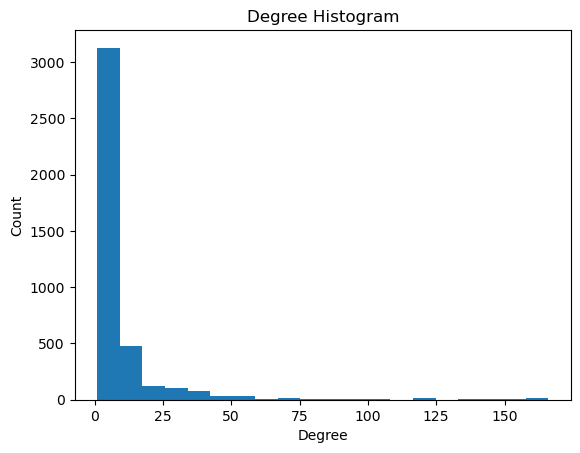

In [57]:
#draw degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

import matplotlib.pyplot as plt

plt.hist(degree_sequence, bins=20)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [14]:
c=nx.connected_components(G)
c=sorted(list(c))
len(c[0])

48

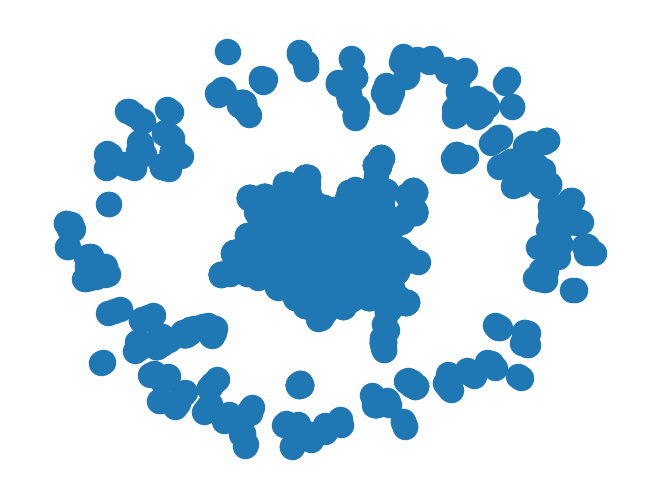

In [15]:
nx.draw(G)

In [9]:
nx.write_graphml(G, "../data/graphs-3/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_filtered.graphml")

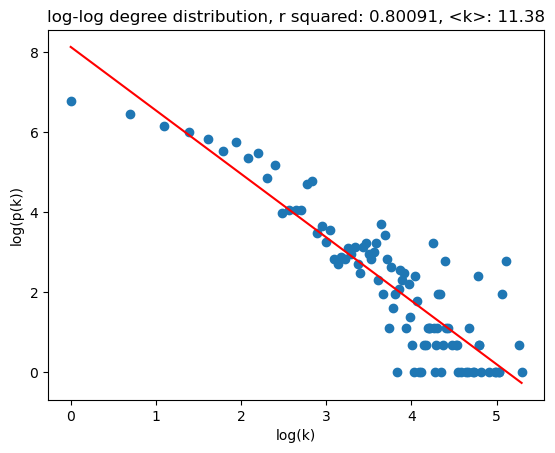

In [66]:
def log_log(G):
    degrees = [G.degree(n) for n in G.nodes()]
    mean_degree = np.mean(degrees)

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    ### regression line
    slope, intercept = np.polyfit(x, y, 1)
    # print(f"SLope: {slope*-1}, intercept: {intercept}")
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    plt.title(f"log-log degree distribution, r squared: {round(r_squared,5)}, <k>: {round(mean_degree, 2)}")
    plt.xlabel("log(k)")
    plt.ylabel("log(p(k))")

    plt.scatter(log_k, log_pk)
    plt.plot(x, slope * x + intercept, color="red")
    plt.show()

log_log(G)

In [67]:
G=nx.read_graphml("../data/graphs-3/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_filtered.graphml")

In [69]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

2262

In [6]:
c=sorted(list(nx.connected_components(G)), key=len, reverse=True)
# len(c[-2])
len(c[0])

5633

In [2]:
import networkx as nx
G=nx.read_edgelist("../data/test/c.coli_gene_pairs_0.6.txt", delimiter="-", nodetype=str)